## Part 6: Inspecting and Comparing Embeddings

In [25]:
import pickle
import numpy as np
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import warnings
from gensim.models import Word2Vec
warnings.filterwarnings('ignore')

In [ ]:
with open('word2vec_embeddings.pkl', 'rb') as f:
    pytorch_data = pickle.load(f)
    pytorch_embeddings = pytorch_data['embeddings']
    pytorch_word2idx = pytorch_data['word2idx']
    pytorch_idx2word = pytorch_data['idx2word']

gensim_full_model = Word2Vec.load('word2vec_text8_gensim.model')
gensim_model = gensim_full_model.wv
w2v_google = KeyedVectors.load('word2vec-google-news-300.model', mmap='r')
fasttext = KeyedVectors.load('fasttext-wiki-news-subwords-300.model', mmap='r')

In [27]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

def get_sentence_embedding(sentence, embeddings, word2idx=None):
    tokens = word_tokenize(sentence.lower())
    vectors = []
    for word in tokens:
        if word2idx and word in word2idx:
            vectors.append(embeddings[word2idx[word]])
        elif word2idx is None and word in embeddings:
            vectors.append(embeddings[word])
    return np.mean(vectors, axis=0) if vectors else np.zeros(embeddings.shape[1] if word2idx else embeddings.vector_size)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mailj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mailj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [28]:
# List of sentences for comparison
sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

# Query sentence
query = "My pet cat is sleeping on the carpet."

In [29]:
for name, embeddings, word2idx in [
    ('PyTorch', pytorch_embeddings, pytorch_word2idx),
    ('Gensim Text8', gensim_model, None),
    ('Word2Vec Google', w2v_google, None),
    ('FastText Wiki', fasttext, None)
]:
    print(f"{name}")
    query_emb = get_sentence_embedding(query, embeddings, word2idx)
    for i, sentence in enumerate(sentences):
        sent_emb = get_sentence_embedding(sentence, embeddings, word2idx)
        sim = cosine_similarity([query_emb], [sent_emb])[0][0]
        print(f"{i+1}. [{sim:.4f}] {sentence}")

PyTorch
1. [0.5361] The cat sat on the mat.
2. [0.4849] A dog is playing in the yard.
3. [0.2297] I need to buy groceries today.
4. [0.2470] The feline was resting on the rug.
5. [0.1652] Canines enjoy outdoor activities.
6. [0.5111] My shopping list includes milk and bread.
7. [0.3975] The weather is beautiful today.
8. [0.2091] Programming requires logical thinking.
Gensim Text8
1. [0.6892] The cat sat on the mat.
2. [0.5846] A dog is playing in the yard.
3. [0.1856] I need to buy groceries today.
4. [0.4738] The feline was resting on the rug.
5. [0.0728] Canines enjoy outdoor activities.
6. [0.4662] My shopping list includes milk and bread.
7. [0.4658] The weather is beautiful today.
8. [0.0681] Programming requires logical thinking.
Word2Vec Google
1. [0.7369] The cat sat on the mat.
2. [0.6483] A dog is playing in the yard.
3. [0.3718] I need to buy groceries today.
4. [0.7794] The feline was resting on the rug.
5. [0.4281] Canines enjoy outdoor activities.
6. [0.4970] My shopping

### Embedding Visualization with t-SNE and UMAP

In [30]:
# Word categories for visualization
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]

all_words = animals + foods
labels = ['animal'] * len(animals) + ['food'] * len(foods)

In [31]:
def visualize_embeddings(configs):
    fig, axes = plt.subplots(len(configs), 2, figsize=(14, 5 * len(configs)))
    for idx, (name, embeddings, word2idx) in enumerate(configs):
        vectors, words, cats = [], [], []
        for i, word in enumerate(all_words):
            if (word2idx and word in word2idx) or (word2idx is None and word in embeddings):
                vectors.append(embeddings[word2idx[word]] if word2idx else embeddings[word])
                words.append(word)
                cats.append(labels[i])
        
        for col, (reducer, method) in enumerate([(TSNE(random_state=42), 't-SNE'), (umap.UMAP(random_state=42), 'UMAP')]):
            coords = reducer.fit_transform(np.array(vectors))
            axes[idx, col].scatter(coords[:, 0], coords[:, 1], c=[labels.index(c) for c in cats])
            for i, word in enumerate(words):
                axes[idx, col].annotate(word, coords[i])
            axes[idx, col].set_title(f"{name} - {method}")

### All Embeddings Visualization (t-SNE & UMAP)

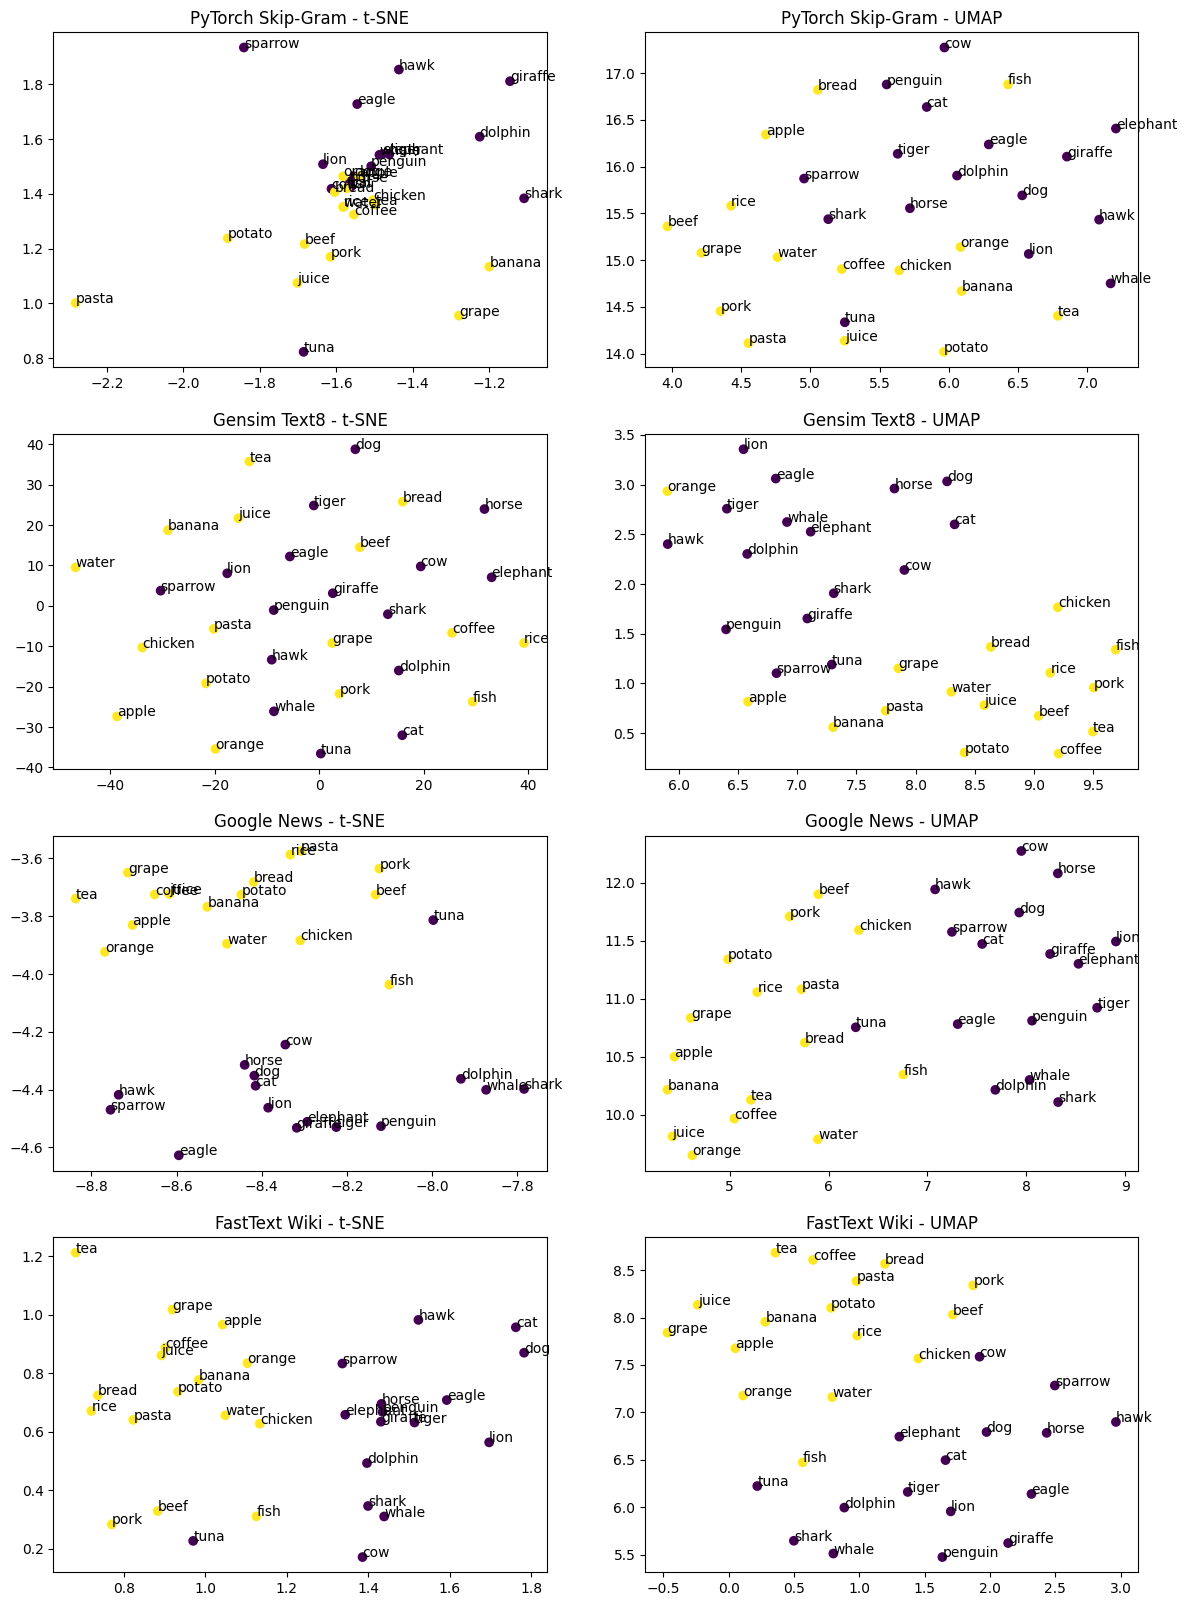

In [32]:
visualize_embeddings([
    ('PyTorch Skip-Gram', pytorch_embeddings, pytorch_word2idx),
    ('Gensim Text8', gensim_model, None),
    ('Google News', w2v_google, None),
    ('FastText Wiki', fasttext, None)
])

## Part 7: Short Answer Questions


### Question 1: Which embeddings performed best at capturing sentence meaning?


The word2vec Google News embeddings performed best at capturing sentence meaning, followed by FastText, then Gensim Text8, with our own PyTorch embeddings performing the worst. Looking at the most semantically similar sentence "The feline was resting on the rug", Word2Vec Google scored 0.7794, Gensim Text8 scored 0.4738, and PyTorch only managed 0.2470. However, FastText achieved a similarity of 0.9247. This would suggest that FastText was the best, however I also noted how other non-related sentences were scored. For example, "Programming requires logical thinking" was given a score of 0.61 by FastText, but only 0.30 by Google. A lower score, closer to 0 here would be better, because if the sentences are completely non-related, we would expect them to be orthogonal, or have a cosine similarity of 0. Similarly, the sentence "My Dog is playing in the yard" I would expect to get a low, maybe even negative score, as it can be considered the opposite of our query. If this is the case I would expect a score of -1, however given that the context is very similar the scores were still positive, but Google gave it a lower score. So FastText showed the highest similarity scores for related sentences it failed to maintained reasonable discrimination for unrelated ones, which is why I chose Google to be the best. The visualizations also confirm this, where Google and FastText's UMAP and T-SNE plot shows very similar discrimination between animals and food. While FastText had a little tighter clusters, it was negligible compared to Google, which still had very distinct clusters.

### Question 2: Were the pretrained embeddings significantly better than your own? Why or why not?


Yes, the pretrained embeddings were significantly better my own model. The pretrained Word2Vec Google achieved 0.7794 similarity on the semantically similar sentence "The feline was resting on the rug" compared to our PyTorch's 0.2470. Similarly FastText performed even better at 0.9247, nearly 4x better than our PyTorch model. The Gensim model gave this a sentence of 0.4738 which is also worse the FastText and Goodle. It is interesting to note that while our PyTorch model struggled with this similar sentence, it did perform reasonably well on the non-related sentences, giving "Programming requires logical thinking" a score of 0.2122, which is better than FastText's 0.6106, and closer to Google News' 0.3043. However, this could be attributed to our model's embeddings overall being less semantically rich, leading to less extreme similarity scores, which we observe in all of the sentences having relatively low similarity scores compared to the pretrained models.

The visualizations tell us the same thing. In the t-SNE and UMAP plots, the pretrained models show very clear, tight custers strong separation between animals and foods. In contrast, our PyTorch embeddings show significant mixing of a single cluster in the t-SNE plot, and the UMAP showing some seperation, but still no clear boundary between animals and food. Gensim performed slightly better than our Pytorch implementeation but still shows more mixing than the pretrained models.

### Question 3: What factors might explain the differences in performance?

Several factors could explain the differences in performance that we observed across the four  models. The most significant factor is the size of the data used to train the models. The pretrained models were trained on billions of words from sources like Google News and Wikipedia, while our text8 corpus contains only about 100 million characters. During the data preparation process we also discarded a lot of words that showed up less than 50 times, which could get rid of some nuacned context for the embeddings. This big difference in training data could explains why Word2Vec Google and FastText learned much better semantic representations than our models. Similary vocabulary coverage could lead to difference. By removing less common words from out already smaller training corpus, some influential but less common words may be missing or underrepresented in our models, limiting their ability to find accurate embeddings. So the quality of train training corpus is very important. The text8 corpus is preprocessed Wikipedia text, while Google News and the other sources could have more diverse natural language that is a better representation real-world usage.

Another factor is dimensions of the embeddings. The pretrained models use a 300-dimensional vectors compared to ours which is only 100 dimensions. This gives the pretrained model three times more dimensions to capture nuanced semantic relationships and meaning. The pretrained models could've also benefited from more extensive hyperparameter tuning and longer training periods. Design choses, like FastText's subword-based approach, could also helps it better handle morphological variations like "cat" versus "feline" and generalize better to rare words.


## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>


I used Claude Sonnet 4.5 to help me quickly write solutions to the coding questions. I made sure to clearly state the inputs and outputs schemas as well as my thought process of what the solutions should be before having Claude quickly write the code for me. I then verified that the code ran and the logic was what I had intended by looking at the outputs, and reading the documentation on functions I wasn't familiar with. If the code wasn't what I intended, I made the neccessary changes manually. I also used the built in autocomplete in VSCode to help guid me for the written questions.